  RMSE: 5.818504766725656
  MAE: 4.557521928505541
  R2 score: 0.700136253843676


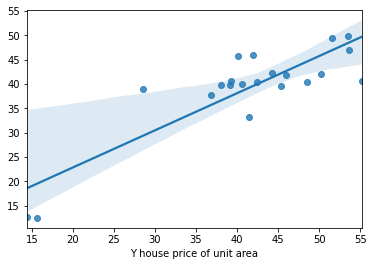

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

import mlflow
import mlflow.sklearn
 
import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


# Read and split data
url = 'https://drive.google.com/file/d/1VRGnIVDBmISVl9skNVzld9dO28mWPNVL/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.05,random_state = 0)

# Training Model
reg = LinearRegression()
reg.fit (X_train, y_train)

# Testing Model
y_pred = reg.predict(X_test)

# Evaluat Model 
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

(rmse, mae, r2) = eval_metrics(y_test, y_pred)

print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2 score: %s" % r2)

with open("metrics.txt", 'w') as outfile:
        outfile.write("RMSE: " + str(rmse) + "\n")
        outfile.write("MAE: " + str(mae) + "\n")
        outfile.write("R2 score: " + str(r2) + "\n")

with mlflow.start_run():
    mlflow.set_experiment(experiment_name="mlflow_CI_CD")
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(reg, "model")
    
# Draw, show, and save regplot
ax = sns.regplot(x=y_test,y=y_pred,fit_reg=True)
ax.figure.savefig('regplot.png')

# Create (Pickle file) and save regression model to disk
pickle.dump(reg, open('dockerfille_dev/model.pkl','wb'))

In [30]:
# Copy the update files (Ml model and Flask web Api) and Restart Service with container (in the background )
os.system("docker cp dockerfille_dev/flask_api.py real_estat_price_container:/usr/app/flask_api.py\
&& docker cp dockerfille_dev/model.pkl real_estat_price_container:/usr/app/model.pkl\
&& docker restart real_estat_price_container")

# Copy the update folder (mlruns) and Restart Service with container (in the background )
os.system("docker cp mlruns/. mlflow_contaier:/usr/app_mlflow/mlruns\
&& docker restart mlflow_contaier")

0